## Initial imports

In [1]:
import scm.plams as plams
import os
import numpy as np

## Create initial benzene system

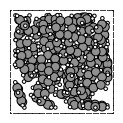

In [2]:
benzene_box = plams.packmol(plams.from_smiles("c1ccccc1", forcefield="uff"), density=0.875, n_molecules=40)
plams.plot_molecule(benzene_box);

## Equilibration MD simulation

Short equilibration MD simulation at 300 K for 5 ps with the GAFF force field and automatic atom typing. 

In [3]:
s = plams.Settings()
s.input.ForceField.Type = "GAFF"
s.input.ForceField.AnteChamberIntegration = "Yes"
eq_job = plams.AMSNVTJob(
    settings=s,
    molecule=benzene_box,
    name="equilibration",
    nsteps=5000,
    timestep=1.0,
    temperature=300,
    thermostat="Berendsen",
)
eq_job.run();

[17.03|17:48:37] JOB equilibration STARTED
[17.03|17:48:37] JOB equilibration RUNNING
[17.03|17:49:35] JOB equilibration FINISHED
[17.03|17:49:35] JOB equilibration SUCCESSFUL


## Production MD simulation

Enable the "Bin log" for Pressure tensor and Time. This stores these quantities at every time step of the simulation, even if the structure is not stored. It is required to be able to calculate viscosity from the Green-Kubo relation.

Here, we run a very short MD simulation of 200 ps. Typically, to converge the viscosity you would need longer simulations.

The time step is quite large at 1 fs. You may want to decrease it (and increase the number of MD steps correspondingly).

In [ ]:
prod_job = plams.AMSNVTJob.restart_from(
    eq_job,
    name="production",
    nsteps=200000,
    timestep=1,
    temperature=300,
    thermostat="NHC",
    tau=100,
    binlog_pressuretensor=True,
    binlog_time=True,
)

In [5]:
prod_job.run()

[17.03|17:49:35] JOB production STARTED
[17.03|17:49:35] JOB production RUNNING
[17.03|18:35:10] JOB production FINISHED
[17.03|18:35:11] JOB production SUCCESSFUL


## Calculate the viscosity autocorrelation integral

In [6]:
from scm.plams.recipes.md.trajectoryanalysis import AMSViscosityFromBinLogJob

job = AMSViscosityFromBinLogJob(previous_job=prod_job)
job.run();

[17.03|18:35:11] JOB plamsjob STARTED
[17.03|18:35:11] JOB plamsjob RUNNING
[17.03|18:35:29] JOB plamsjob FINISHED
[17.03|18:35:30] JOB plamsjob SUCCESSFUL


## Plot the results

The viscosity is the limiting value of the viscosity integral.

The viscosity integral **must** converge to a near-constant value. If it is not close to converging, then you should run a longer MD simulation.

To better estimate the viscosity, a double-exponential function is fitted to the viscosity integral curve. This makes it easier to get a numerical value for the viscosity.

$\eta(t) = A(\lambda (1 - \exp(-t/\tau _1) + (1-\lambda) (1- \exp(-t/\tau _2))$

The parameters $A$, $\lambda$, $\tau _1$, and $\tau _2$ are fitted and available as ``popt[0]``, ``popt[1]``, ``popt[2]``, and ``popt[3]``.



In [7]:
x, viscosity_integral = job.results.get_viscosity_integral()
popt, x_fit, fit_viscosity_integral = job.results.get_double_exponential_fit()

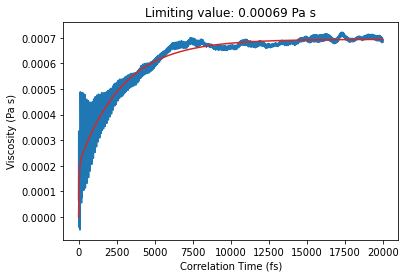

In [8]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.set_title(f"Limiting value: {popt[0]:.5f} Pa s")
ax.plot(x, viscosity_integral, color="tab:blue")
ax.plot(x_fit, fit_viscosity_integral, color="tab:red")
ax.set_xlabel("Correlation Time (fs)")
ax.set_ylabel("Viscosity (Pa s)");